<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignments/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from keras.datasets import fashion_mnist

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


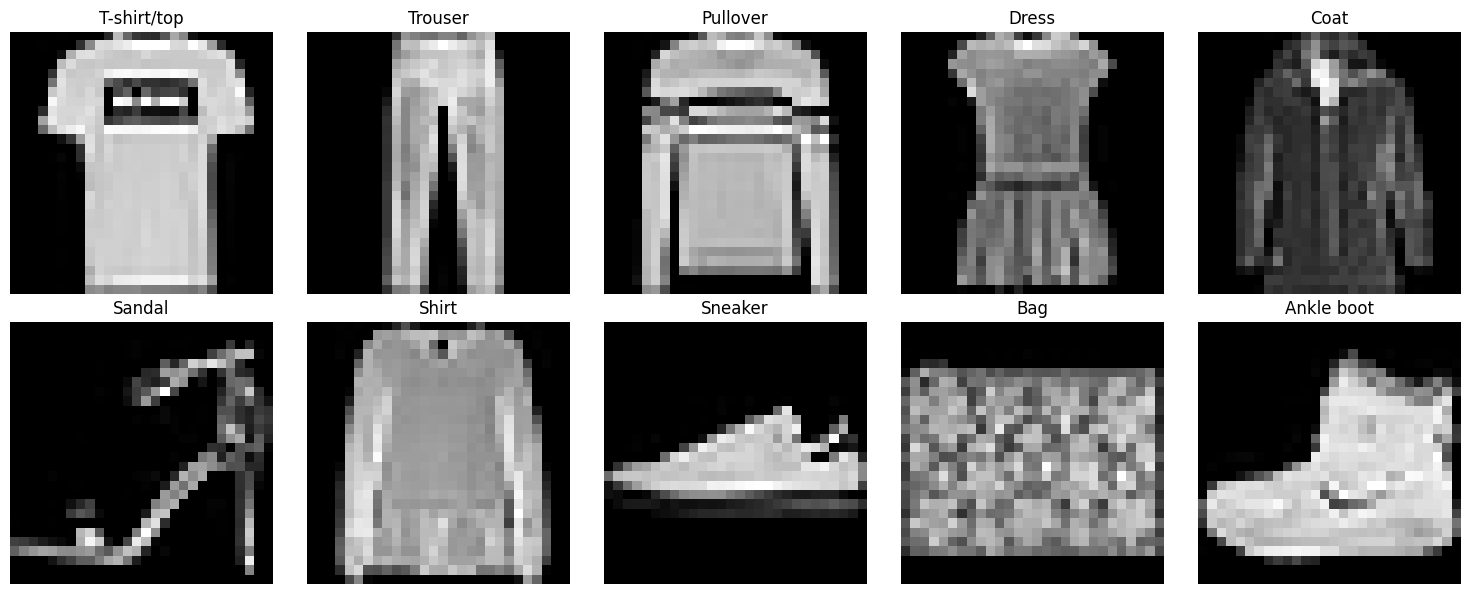

In [110]:
# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Display one image from each class
for i in range(len(class_names)):
    # Find the first occurrence of the class in the dataset
    idx = np.where(train_labels == i)[0][0]

    # Display the image
    axes[i].imshow(train_images[idx], cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [111]:
print(train_images[0].shape)

(28, 28)


In [112]:
print(train_labels.shape)

(60000,)


In [113]:
def weights_initialization(num_neurons, initializer):
  """
  num_neurons = list of number of neurons at each layer starting from the input layer and ending at output layer
  initializer = 'random' or 'xavier'

  Returns: initialized weight matrices and bias vectors
  """
  mean=0
  std_dev=1

  W_matrices = []
  b_vectors = []

  for i in range(len(num_neurons)-1):
    rows = num_neurons[i+1]
    cols = num_neurons[i]

    if initializer == 'random':

      weight_matrix = np.random.normal(mean, std_dev, size=(rows, cols))

    elif initializer == 'xavier':

      upper_bound = np.sqrt(6.0/(rows + cols))
      lower_bound = -1*upper_bound
      weight_matrix = np.random.uniform(low = lower_bound, high = upper_bound, size = (rows, cols))

    else:
      print('initializer invalid')


    bias_vector = np.zeros((rows,))

    W_matrices.append(weight_matrix)
    b_vectors.append(bias_vector)


  return W_matrices, b_vectors

In [114]:
def relu(x):
  """
  Rectified Linear Unit (ReLU) activation function
  """
  return np.maximum(0, x)

def sigmoid(x):
  """
  Sigmoid activation function
  """
  # x = np.float128(x)
  return 1 / (1 + np.exp(-x))

def tanh(x):
  """
  Hyperbolic tangent (tanh) activation function
  """
  # x = np.float128(x)
  return np.tanh(x)
def softmax(x):

  """
  Softmax function for output layer
  """
  # x = np.float128(x)
  return np.exp(x) / np.sum(np.exp(x))
def activation_output(x, activation_function):
  """
  activation_function = 'relu', 'sigmoid', 'tanh'
  """
  if activation_function == 'relu':
    return relu(x)
  elif activation_function == 'sigmoid':
    return sigmoid(x)
  elif activation_function == 'tanh':
    return tanh(x)

In [135]:
def forward_propagation(x, W_matrices, b_vectors, activation_functions):
  """
  forward propagation
  """
  L_hidden = len(W_matrices) - 1

  for i in range(L_hidden+1):

    weight_matrix = W_matrices[i]
    bias_vector = b_vectors[i]

    if i==0:
      pre_activation_vec = np.add(np.matmul(weight_matrix, x), bias_vector)
      post_activation_vec = activation_output(pre_activation_vec, activation_functions[i])

      #print("Layer: ", i, "output shape: ", post_activation_vec.shape, "\n")

    elif i==L_hidden:

      pre_activation_vec = np.add(np.matmul(weight_matrix, post_activation_vec), bias_vector)
      output_vec = softmax(pre_activation_vec)

      """
      print("Layer: ", i, "output shape: ", output_vec.shape)
      print("post_activation_vec: ", output_vec)
      print("sum of output values: ", np.sum(output_vec, axis=0),"\n")
      """
    elif i!=0 & i!=L_hidden:

      pre_activation_vec = np.add(np.matmul(weight_matrix, post_activation_vec), bias_vector)
      post_activation_vec = activation_output(pre_activation_vec, activation_functions[i])

      #print("Layer: ", i, "output shape: ", post_activation_vec.shape, "\n")

  return output_vec

In [136]:
x = train_images[0].flatten('C')
print("image dim: ", train_images[0].shape)
print("after flattening ", x.shape)


# number of neurons at each layer starting from the input layer and ending at output layer
num_ip_neurons = len(x)
num_op_neurons = 10
num_neurons = [num_ip_neurons, 15, 12, num_op_neurons]

print(num_neurons)

# list the activation function to be used for each hidden layer starting from the lowest layer
activation_functions = ['relu', 'sigmoid']

W_matrices, b_vectors = weights_initialization(num_neurons, 'random')

op = forward_propagation(x, W_matrices, b_vectors, activation_functions)

print("output (probabilities) : ", op, "\n")
print("sum of output values (total probability): ", np.sum(op, axis=0))

image dim:  (28, 28)
after flattening  (784,)
[784, 15, 12, 10]
output (probabilities) :  [0.01526428 0.28001986 0.04568346 0.13429547 0.04076727 0.00166739
 0.00954368 0.19835291 0.05167426 0.22273141] 

sum of output values (total probability):  0.9999999999999999


<ipython-input-114-b9be8af083a6>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


3


In [ ]:
import wandb
wandb.init(project="test_features")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arunangshudutta218 (arunangshudutta218-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:

# Save the figure and log it to wandb
plt.savefig("fashion_mnist_classes.png")
wandb.log({"Fashion MNIST Classes": wandb.Image("fashion_mnist_classes.png")})

# Log individual images to wandb
for i in range(len(class_names)):
    idx = np.where(train_labels == i)[0][0]
    wandb.log({f"{class_names[i]}": wandb.Image(train_images[idx], caption=class_names[i])})

# Finish the wandb run
wandb.finish()

<Figure size 640x480 with 0 Axes>

In [ ]:
wandb.init(project="test_features")
# Create a wandb.Table to store images and metadata
table = wandb.Table(columns=["Index", "Class Name", "Image"])

# Add images and metadata to the table
for idx in range(50):  # Log the first 50 examples (adjust as needed)
    image = train_images[idx]
    label = train_labels[idx]
    class_name = class_names[label]

    # Add data to the table
    table.add_data(idx, class_name, wandb.Image(image, caption=class_name))

# Log the table to wandb
wandb.log({"examples": table})

# Finish the wandb run
wandb.finish()


789
789.0


In [ ]:
p